In [262]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

import operator

from scipy.stats import norm
import scipy.stats as st
import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [263]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

full = train.append(test, ignore_index = True,sort=False)

In [264]:
full.drop(['LotFrontage'],axis=1,inplace = True) 

full.MasVnrArea = full.MasVnrArea.fillna(0.) 


full.GarageCars = full.GarageCars.fillna(0.) 
full.GarageArea = full.GarageArea.fillna(0.) 
full.GarageYrBlt = full.GarageYrBlt.fillna(0.)

full.BsmtFinSF1 = full.BsmtFinSF1.fillna(0.)
full.BsmtFinSF2 = full.BsmtFinSF2.fillna(0.)
full.BsmtUnfSF = full.BsmtUnfSF.fillna(0.)
full.BsmtFullBath = full.BsmtFullBath.fillna(0.)
full.BsmtHalfBath = full.BsmtHalfBath.fillna(0.)
full.TotalBsmtSF = full.TotalBsmtSF.fillna(0.)


In [265]:
full.drop(['PoolQC'],axis=1,inplace = True) 
full.drop(['MiscFeature'],axis=1,inplace = True) 
full.drop(['Alley'],axis=1,inplace = True)   
#full.drop(['Fence'],axis=1,inplace = True) 


full['Electrical'] = full['Electrical'].fillna(full['Electrical'].mode()[0])  

full['SaleType'] = full['SaleType'].fillna(full['SaleType'].mode()[0]) 

full['MSZoning'] = full['MSZoning'].fillna(full['MSZoning'].mode()[0])  

full['KitchenQual'] = full['KitchenQual'].fillna(full['KitchenQual'].mode()[0]) 



full['MasVnrType'] = full['MasVnrType'].fillna('Missing')    

full['Exterior1st'] = full['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
full['Exterior2nd'] = full['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])    

full['Fence'] = full['Fence'].fillna('Missing')
full['FireplaceQu'] = full['FireplaceQu'].fillna('Missing')

full['Functional'] = full['Functional'].fillna('Typ')

full['GarageType'] = full['GarageType'].fillna('Missing')
full['GarageFinish'] = full['GarageFinish'].fillna('Missing')
full['GarageQual'] = full['GarageQual'].fillna('Missing')
full['GarageCond'] = full['GarageCond'].fillna('Missing')


    
full['BsmtExposure'] = full['BsmtExposure'].fillna('Missing')
full['BsmtFinType1'] = full['BsmtFinType1'].fillna('Missing')
full['BsmtFinType2'] = full['BsmtFinType2'].fillna('Missing')
full['BsmtQual'] = full['BsmtQual'].fillna('Missing')
full['BsmtCond'] = full['BsmtCond'].fillna('Missing')

full.drop(['Utilities'],axis=1,inplace = True) 
full.drop(['Street'],axis=1,inplace = True)

In [266]:
train = full[full.SalePrice.notnull()]
test = full[full.SalePrice.isnull()]

In [267]:
train = train[train['GrLivArea'] < 4500]
train = train[train['LotArea'] < 100000]
train = train[train['TotalBsmtSF'] < 3000]
train = train[train['1stFlrSF'] < 2500]
train = train[train['BsmtFinSF1'] < 2000]

In [268]:
numerical_feature = train.dtypes[train.dtypes != "object"].index

In [269]:
Categorical_features = []
for x in full.columns:
    if x not in numerical_feature:
        Categorical_features.append(x)

### Understanding Different section of house effect on sale Price

Here we will try to figure out what are most important factors affecting sale price and how different section of home has effect on it 


Lets start by findind two most co-relted varibale to sale price in our dataset

In [ ]:
focus_cols = ['SalePrice']
print(train.corr(method='spearman').filter(focus_cols).drop(focus_cols).sort_values(focus_cols,ascending=False).head(2))

* **OverallQual** and **GrLivArea** seems to have higest effect on price

#### lets start with understanding Overall quality relation with respect to Sale Price

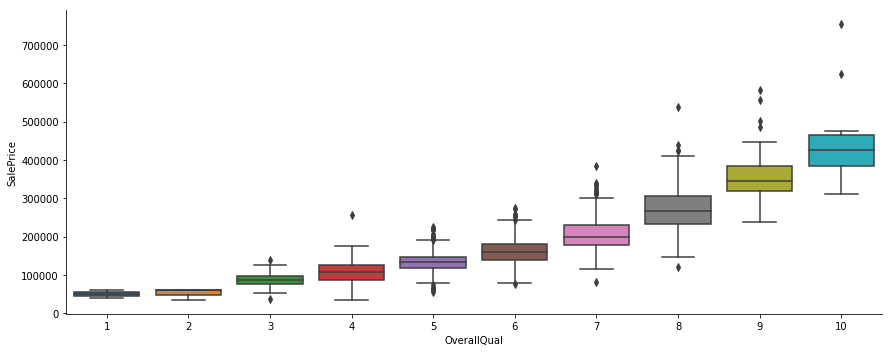

In [272]:
g = sns.factorplot(x="OverallQual",y="SalePrice",data=train,kind='box',size = 5,aspect=2.5)

* it is quite clear that with rise in OverallQual and sale price will rise


#### what are relation of area and quality with sale price 

Text(0.5,1,'GrLiv - SalePrice w.r.t OverallQual')

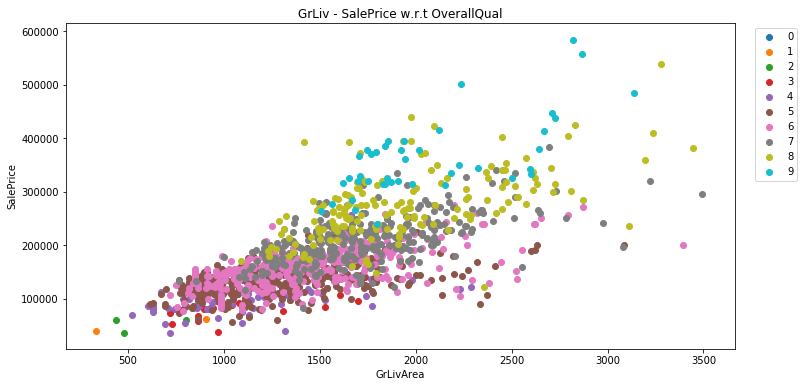

In [273]:
plt.figure(figsize = (12,6))

for val in range(10):# for eachoverall quality
    indeX = train.OverallQual == val # list all index for whcuh overall quality is value of that loop
    plt.scatter(train.GrLivArea.loc[indeX], train.SalePrice.loc[indeX], label = val) # scatter plot at area and saleprice commpon and plot qiality 
plt.legend(bbox_to_anchor = [1.1, 1])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLiv - SalePrice w.r.t OverallQual')

    

* OverallQual is the very good variables Variables regard of explaining SalePrice
* OverallQual causes different SalePrice where having same "GrLivArea". We have to put a strong attention on OverallQual
* OverallQual was proportional to SalePrice
* Even though Living area does look to have liner realtionship with sale price overall quality matter more

##### lets square qulaity and see effect

Mean squared error: 1770569152.99


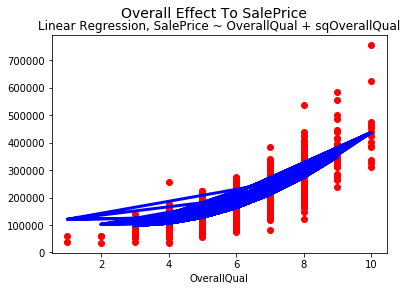

In [271]:
cubicQual = train.groupby(['OverallQual'])['SalePrice'].mean().round(0)
testTrain = train.loc[:, ['OverallQual', 'SalePrice']].copy()
testTrain['sqOverallQual'] = np.power(testTrain['OverallQual'],2) # squaring overall quality

mdl = linear_model.LinearRegression()
mdl.fit(testTrain[['OverallQual', 'sqOverallQual']], testTrain['SalePrice'])
y_pred = mdl.predict(testTrain[['OverallQual', 'sqOverallQual']])
print("Mean squared error: %.2f" % mean_squared_error(y_pred, testTrain.SalePrice))


plt.scatter(testTrain['OverallQual'], testTrain['SalePrice'],  color='r')
plt.plot(testTrain['OverallQual'], y_pred, color='blue', linewidth=3)
plt.title('Linear Regression, SalePrice ~ OverallQual + sqOverallQual', fontsize = 12)
plt.xlabel('OverallQual')
#plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('Overall Effect To SalePrice', fontsize = 14) # Add a centered title to the figure.

plt.show()


* Square of OverallQual was a good variables since linear regression

#### Lets focus on other part of house like basement and upper floor


Text(0.5,1,'Exsitence or Not of Bsmt and 2ndFlr')

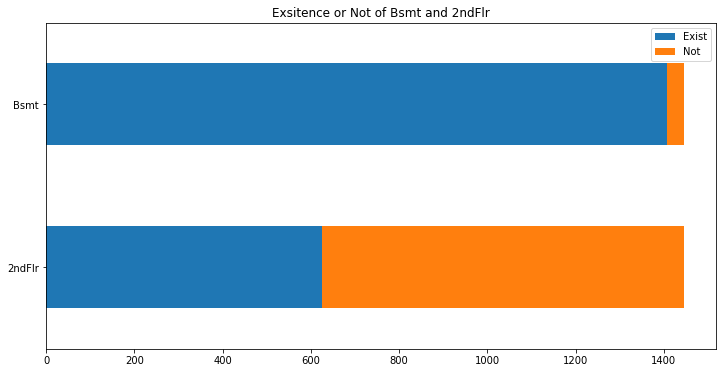

In [261]:
plt.figure(figsize = (12,6))
tf_train = train[['OverallQual','2ndFlrSF', 'TotalBsmtSF', 'SalePrice']].copy()

tf_train['GrLivArea'] = train['GrLivArea'].copy()
tf_train['2ndFlr'] = 'Exist'
tf_train.loc[tf_train['2ndFlrSF'] == 0 ,'2ndFlr'] = 'Not'
tf_train['Bsmt'] = 'Exist'
tf_train.loc[tf_train['TotalBsmtSF'] == 0 ,'Bsmt'] = 'Not'


ax1 = plt.subplot2grid((1,1),(0,0))
tmp = tf_train[['2ndFlr', 'Bsmt']].apply(pd.Series.value_counts).T
tmp.plot.barh(stacked = True, ax = ax1)
ax1.set_title('Exsitence or Not of Bsmt and 2ndFlr', fontsize = 12)

* most houses do have basement 
* 2nd floor dosent always exist

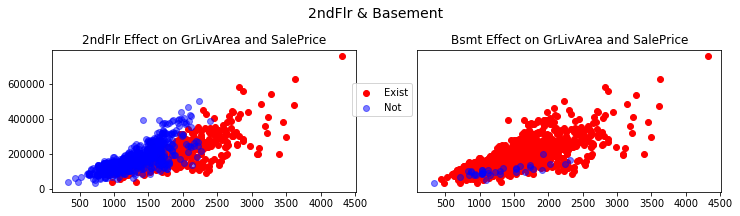

In [274]:
plt.figure(figsize = (12,6))

ax2 = plt.subplot2grid((2,2), (0,0))
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] == 'Exist'], color = 'r', alpha = 1, label = 'Exist')
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] != 'Exist'], color = 'b', alpha = 0.5, label = 'Not')
ax2.set_title('2ndFlr Effect on GrLivArea and SalePrice')
ax2.legend(bbox_to_anchor = [1.2, 0.8])

ax3 = plt.subplot2grid((2,2), (0,1))
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] == 'Exist'], color = 'r', alpha = 1)
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] != 'Exist'], color = 'b', alpha = 0.5)
ax3.set_yticks([])
ax3.set_title('Bsmt Effect on GrLivArea and SalePrice')
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.suptitle('2ndFlr & Basement', fontsize = 14)
plt.show()

* 2ndFlrSF depressed the power of GrLivArea toward SalePrice
* Bsmt has nothing related to the price

#### What does Bathroom has effect on sale price ?

In [275]:
groups = train.groupby(['FullBath', 'HalfBath']) # group by full and half bathroom 
groups.describe()

1stFlrSF                                                    \
                     count         mean         std     min      25%     50%   
FullBath HalfBath                                                              
0        0             3.0   832.000000  308.596824   480.0   720.00   960.0   
         1             3.0  1359.333333  469.596990   904.0  1118.00  1332.0   
         2             3.0  1294.666667   94.495150  1224.0  1241.00  1258.0   
1        0           466.0   983.575107  228.684042   334.0   848.00   950.5   
         1           180.0  1056.894444  319.939546   483.0   815.75  1059.5   
         2             4.0   998.750000   65.885633   902.0   984.50  1026.0   
2        0           422.0  1415.530806  329.209747   372.0  1201.00  1436.5   
         1           330.0  1065.727273  341.352938   520.0   810.25   992.5   
         2             5.0  1155.800000  232.239532   896.0   912.00  1272.0   
3        0            13.0  1339.000000  390.308425   495.0  1182.00  1307.0   
         1            16.0  1550.500000  412.899342   990.0  1170.75  1473.5   

                                   2ndFlrSF                ...   YearRemodAdd  \
                       75%     max    count         mean   ...            75%   
FullBath HalfBath                                          ...                  
0        0         1008.00  1056.0      3.0     0.000000   ...         1990.5   
         1         1587.00  1842.0      3.0    64.000000   ...         1983.0   
         2         1330.00  1402.0      3.0     0.000000   ...         1993.0   
1        0         1094.75  1867.0    466.0    90.858369   ...         1996.0   
         1         1248.50  2097.0    180.0   357.744444   ...         1996.5   
         2         1040.25  1041.0      4.0   859.500000   ...         1976.0   
2        0         1650.00  2392.0    422.0   166.400474   ...         2006.0   
         1         1201.00  2129.0    330.0   851.057576   ...         2005.0   
         2         1338.00  1361.0      5.0  1058.200000   ...         1977.0   
3        0         1636.00  1959.0     13.0   973.923077   ...         2005.0   
         1         1864.75  2444.0     16.0  1362.687500   ...         2006.0   

                          YrSold                                          \
                      max  count         mean       std     min      25%   
FullBath HalfBath                                                          
0        0         2001.0    3.0  2007.333333  2.309401  2006.0  2006.00   
         1         1987.0    3.0  2008.333333  2.081666  2006.0  2007.50   
         2         2007.0    3.0  2008.000000  1.000000  2007.0  2007.50   
1        0         2009.0  466.0  2007.845494  1.335113  2006.0  2007.00   
         1         2010.0  180.0  2007.766667  1.312169  2006.0  2007.00   
         2         1988.0    4.0  2007.000000  0.816497  2006.0  2006.75   
2        0         2010.0  422.0  2007.824645  1.333849  2006.0  2007.00   
         1         2010.0  330.0  2007.824242  1.327527  2006.0  2007.00   
         2         2003.0    5.0  2008.600000  1.140175  2007.0  2008.00   
3        0         2007.0   13.0  2007.384615  1.325296  2006.0  2006.00   
         1         2009.0   16.0  2007.250000  1.341641  2006.0  2006.00   

                                            
                      50%      75%     max  
FullBath HalfBath                           
0        0         2006.0  2008.00  2010.0  
         1         2009.0  2009.50  2010.0  
         2         2008.0  2008.50  2009.0  
1        0         2008.0  2009.00  2010.0  
         1         2008.0  2009.00  2010.0  
         2         2007.0  2007.25  2008.0  
2        0         2008.0  2009.00  2010.0  
         1         2008.0  2009.00  2010.0  
         2         2009.0  2009.00  2010.0  
3        0         2007.0  2008.00  2010.0  
         1         2007.0  2008.00  2010.0  

[11 rows x 272 columns]

* most house's have combination of either one full bathroom with no or or one half bathroom and 2 full with no or 1 half bathroom
* lets understand how that combination effect price or area

Full Correlation (GrLivArea - SalePrice)  0.73
(1, 0)Correlation 0.45 
(1, 1)Correlation 0.56 
(2, 0)Correlation 0.31 
(2, 1)Correlation 0.75 


Text(0,0.5,'SalePrice')

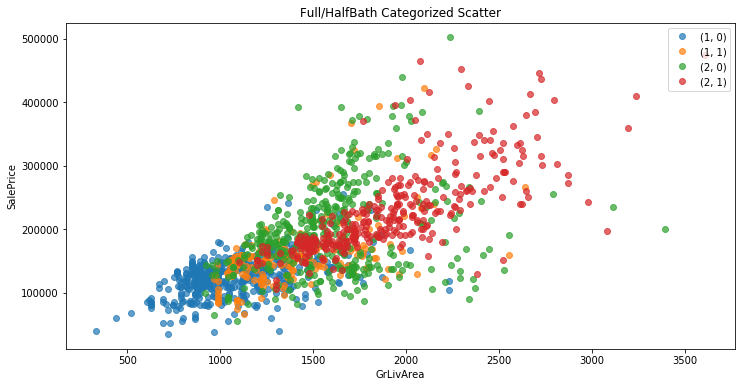

In [276]:
plt.figure(figsize = (12,6))

ax1= plt.subplot2grid((1,1), (0,0), colspan = 2)
colors = sns.color_palette('Set1_r', 4)


print('Full Correlation (GrLivArea - SalePrice) % .2f' % np.corrcoef(train['GrLivArea'], train['SalePrice'])[0][1])



for name, group in groups:
#    print(name)
#    print(group)
    if name in ((1,0), (1,1), (2,0), (2,1)):
        print(str(name) + 'Correlation %.2f ' % np.corrcoef(group['GrLivArea'], group['SalePrice'])[0][1])
        ax1.plot(group['GrLivArea'], group['SalePrice'], marker = 'o', linestyle = '', label = name, alpha = 0.7)
        #print(group['GrLivArea']+group['SalePrice'])
        #print("----------------------------------------------------")

ax1.legend(loc = 'upper right')
ax1.set_title('Full/HalfBath Categorized Scatter')
ax1.set_xlabel('GrLivArea')
ax1.set_ylabel('SalePrice')

they do have little patten but combination of 2 full and 1 half has high co-relation, may be more visualzation required

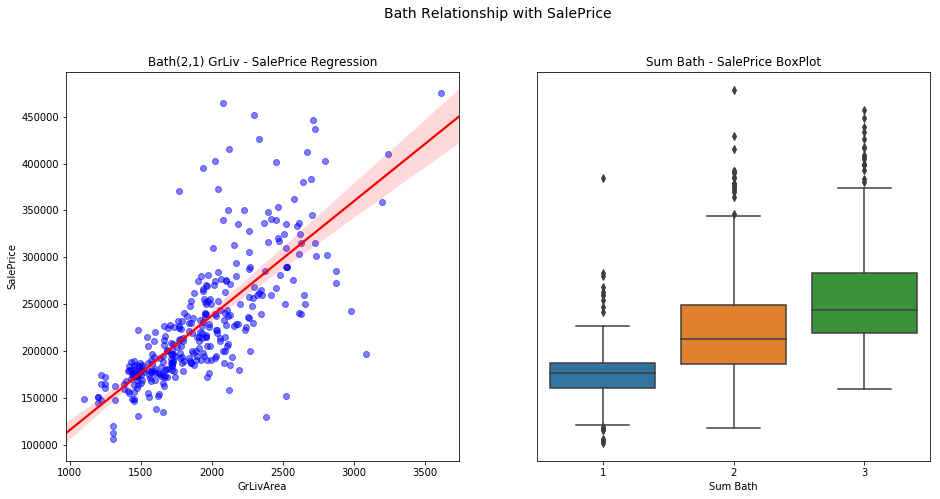

In [277]:
plt.figure(figsize = (12,6))

ax2= plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1)
sns.regplot(x = 'GrLivArea', y = 'SalePrice', order = 1,
            data = train.loc[(train['FullBath'] == 2 ) & (train['HalfBath']==1), ['GrLivArea', 'SalePrice']], 
            ax = ax2, line_kws = {'color' : 'red'}, scatter_kws = {'color' : 'blue', 'alpha' : 0.5})
ax2.set_title('Bath(2,1) GrLiv - SalePrice Regression')


ax3= plt.subplot2grid((1,2), (0,1))
testTrain = train.loc[:, ['GrLivArea', 'SalePrice']].copy() # add living area and sale price
testTrain['Bath'] = train[['FullBath', 'HalfBath']].sum(axis = 1) # add bath which is sum of fill + half 

sns.boxplot(x = 'Bath', y = 'SalePrice', order= [1,2,3], data =testTrain, ax =ax3)
ax3.set_title('Sum Bath - SalePrice BoxPlot')
ax3.set_yticks([])
ax3.set_ylabel('')
ax3.set_xlabel('Sum Bath')

plt.subplots_adjust(0,0,1, 0.9,hspace = 0.5)
plt.suptitle('Bath Relationship with SalePrice', fontsize = 14, y = 1.05)
plt.show()

* The Number of Bath usually increased the SalePrice
* combination of (Full 2, Half1) improved the linearity and decreased the spreadness of SalePrice - GrLivArea.

#### Techical Room


Text(0.5,1,'TotRomm - Bedroom ')

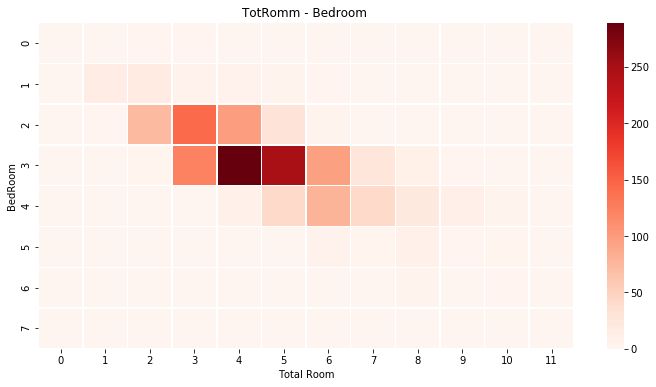

In [279]:
plt.figure(figsize = (12,6))
ax = plt.subplot2grid((1,1), (0,0), rowspan = 2, colspan = 2)
bedr = ['BedroomAbvGr', 'TotRmsAbvGrd']
test = pd.crosstab(train[bedr[0]], train[bedr[1]])
sns.heatmap(test.values, cmap = plt.cm.Reds, ax = ax, linewidths=.5), #yticklabels=False, xticklabels=False)
ax.set_ylabel('BedRoom')
ax.set_xlabel('Total Room')
ax.set_title('TotRomm - Bedroom ')

* clearly total room above ground and no of bedroom are lineraly realted

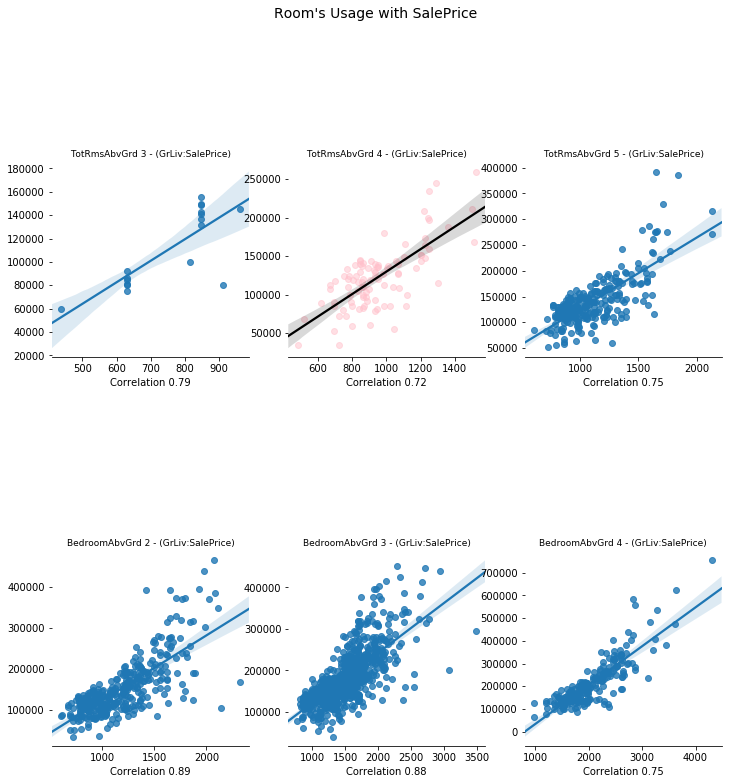

In [280]:


#2.4. Techical Room
plt.figure(figsize = (12,12))


ax2 = plt.subplot2grid((2,3), (0,0))
colors = sns.color_palette('Set2',3)
#pack = [3,4,5]
##val = pack[0]
#print(val)
sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.TotRmsAbvGrd == 3],ax = ax2)
#ax2.set_yticklabels([])
ax2.set_title('TotRmsAbvGrd 3 - (GrLiv:SalePrice)', fontsize = 9)
ax2.set_ylabel('')
ax2.set_xlabel('Correlation ' + str(train.loc[train.TotRmsAbvGrd == 3, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))



ax3 = plt.subplot2grid((2,3), (0,1))

sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.TotRmsAbvGrd == 4], 
            scatter_kws = {'color' : 'pink', 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax3)
#ax3.set_yticklabels([])
ax3.set_ylabel('')
ax3.set_title('TotRmsAbvGrd 4 - (GrLiv:SalePrice)' , fontsize = 9)
ax3.set_xlabel('Correlation ' + str(train.loc[train.TotRmsAbvGrd == 4, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))
#ax3.legend()

ax4 = plt.subplot2grid((2,3), (0,2))
#val = pack[2]
#print(val)

sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.TotRmsAbvGrd == 5],  ax = ax4)
#ax4.set_yticklabels([])
ax4.set_title('TotRmsAbvGrd 5 - (GrLiv:SalePrice)' , fontsize = 9)
ax4.set_ylabel('')
ax4.set_xlabel('Correlation ' + str(train.loc[train.TotRmsAbvGrd == 5, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

#pack = [1,6]

ax5 = plt.subplot2grid((2,3), (1,0))
#val = pack[0]
#print(val)

sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.BedroomAbvGr == 2],ax = ax5)
#ax4.set_yticklabels([])
ax5.set_title('BedroomAbvGrd 2 - (GrLiv:SalePrice)' , fontsize = 9)
ax5.set_ylabel('')
ax5.set_xlabel('Correlation ' + str(train.loc[train.BedroomAbvGr == 1, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

ax6 = plt.subplot2grid((2,3), (1,1))
#val = pack[1]
#print(val)

sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.BedroomAbvGr == 3],ax = ax6)
#ax4.set_yticklabels([])
ax6.set_title('BedroomAbvGrd 3 - (GrLiv:SalePrice)' , fontsize = 9)
ax6.set_ylabel('')
ax6.set_xlabel('Correlation ' + str(train.loc[train.BedroomAbvGr == 6, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))


ax6 = plt.subplot2grid((2,3), (1,2))
#val = pack[1]
#print(val)

sns.regplot(x='GrLivArea', y = 'SalePrice', data = train.loc[train.BedroomAbvGr == 4],ax = ax6)
#ax4.set_yticklabels([])
ax6.set_title('BedroomAbvGrd 4 - (GrLiv:SalePrice)' , fontsize = 9)
ax6.set_ylabel('')
ax6.set_xlabel('Correlation ' + str(train.loc[train.BedroomAbvGr == 2, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))



sns.despine(left = True)


plt.subplots_adjust(top = 0.8, hspace = 1)
plt.suptitle("Room's Usage with SalePrice", fontsize = 14)
plt.show()

* total room above ground also have very good co-relation above 0.7 
* bedroom has very high co-relation with sale price and living area(usually above 0.75)


#### Outside area

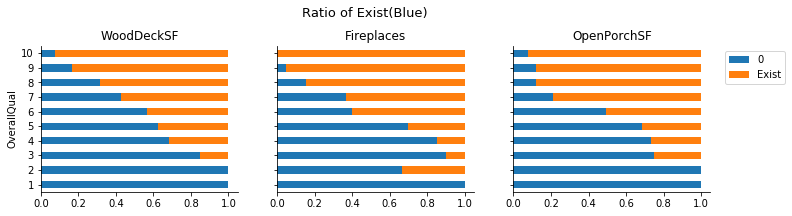

In [281]:
outSide = ['OpenPorchSF', 'Fireplaces','WoodDeckSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch','PoolArea']
dfOut = train[outSide].copy()
for x in outSide:
    dfOut[x].loc[dfOut[x] != 0] = 1
dfOut = dfOut.apply(pd.Series.value_counts).T
dfOut = dfOut / train.shape[0]

px =  plt.figure(figsize = (12,3))
#px.patch.set_facecolor('black')
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#According to OverQuall, WoodDeckSF's Proportion Exist or Not

for x, axis in zip(['WoodDeckSF', 'Fireplaces', 'OpenPorchSF'], [ax1, ax2, ax3]):
    dfOut = train[[x, 'OverallQual']].copy()
 
    dfOut[x].loc[dfOut[x] != 0] = 'Exist'
#    
    tmp = pd.crosstab(dfOut[x], dfOut['OverallQual']).T
    tmp = tmp.divide(tmp.sum(axis = 1), axis = 0)
    tmp.plot.barh(stacked = True, ax = axis, legend = False)
    axis.set_title(x)
    
ax3.legend(bbox_to_anchor = [1.05, 1])
ax2.set_ylabel('')
ax3.set_ylabel('')
ax2.set_yticklabels('')
ax3.set_yticklabels('')
plt.subplots_adjust(top = 0.8)
plt.suptitle('Ratio of Exist(Blue)', fontsize = 13)
sns.despine()
plt.show()

#print((df_train.isnull().sum()[df_train.isnull().sum() != 0]) / df_train.shape[0])
#print('')

* Good Quality House has more outside instrumental places.
* PoolArea, ScreenPorch, 3SsnPorch were almost negligible

In [283]:
#### Fireplace

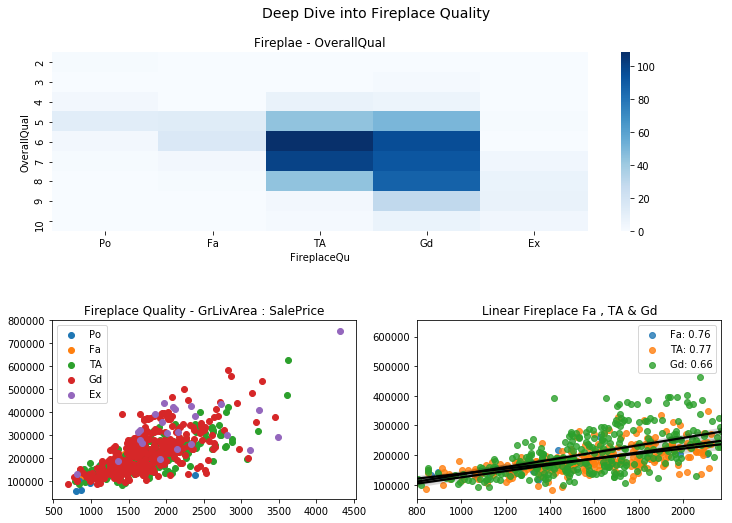

In [282]:
f, ax = plt.subplots(2,2, figsize = (12,8))
hasFire = train.FireplaceQu != 'Missing'
tmp = train.loc[hasFire, ['OverallQual', 'FireplaceQu', 'GrLivArea', 'SalePrice']]

##################################################################################################
# understand relationship of fireplace and quality
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)
res = pd.crosstab(tmp['OverallQual'], tmp['FireplaceQu'])
cols = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
sns.heatmap(res[cols], ax = ax, cmap="Blues")
ax.set_title('Fireplae - OverallQual')

##################################################################################################
# understand fireplace quality relationship with sale price and living area
ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)
for val in cols:
    index2 = tmp['FireplaceQu'] == val
    ax1.scatter(tmp.loc[index2, 'GrLivArea'], tmp.loc[index2,'SalePrice'], label = val)
ax1.legend()
ax1.set_title('Fireplace Quality - GrLivArea : SalePrice')

##################################################################################################

ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

for val in ['Fa', 'TA' , 'Gd' ]:
    index2 = tmp['FireplaceQu'] == val
    data = tmp.loc[index2, ['GrLivArea', 'SalePrice']]
    label = str(val) + ': '+ str(data.corr().loc['GrLivArea', 'SalePrice'].round(2))
    sns.regplot('GrLivArea', 'SalePrice', data = data, ax = ax2,
               line_kws = {'color' : 'k'}, label = label)
ax2.legend()
ax2.set_title('Linear Fireplace Fa , TA & Gd')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.subplots_adjust(top = 0.9, hspace = 0.5)
plt.suptitle('Deep Dive into Fireplace Quality', fontsize = 14)
plt.show()

* fireplace is linear related to overall quality
* only Fa,TA and Gd has some decent linear relationship
* Ex and Po does not have good linear realtionship, which is clarly visible by looking where Ex are so spread around

#### Effect of Season


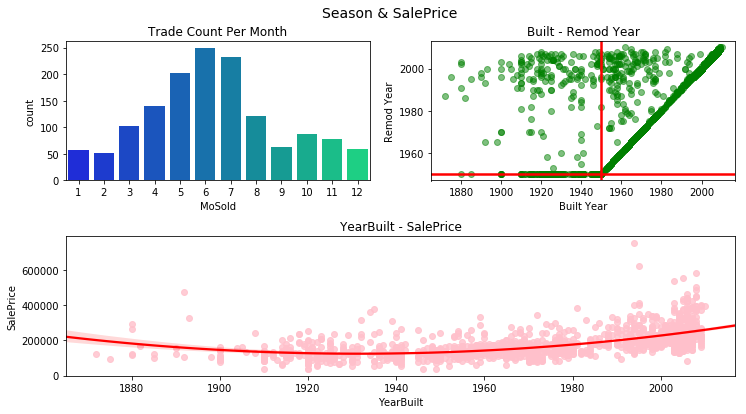

In [284]:
season = ['YearBuilt', 'YearRemodAdd','GarageYrBlt', 'MoSold', 'YrSold', 'SalePrice']
plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0))
sns.countplot(x = 'MoSold', palette = sns.color_palette('winter', 12), data =train, ax = ax1)
ax1.set_title('Trade Count Per Month')

ax2 = plt.subplot2grid((2,2), (0,1))
ax2.scatter(x = train['YearBuilt'], y = train['YearRemodAdd'], alpha = 0.5, color = 'g')
ax2.axvline(1950, color = 'red', linewidth = 2.5)
ax2.axhline(1950, color = 'red', linewidth = 2.5)
ax2.set_xlabel('Built Year')
ax2.set_ylabel('Remod Year')
ax2.set_title('Built - Remod Year')

ax3 = plt.subplot2grid((2,2), (1,0), colspan = 2)
sns.regplot(x = 'YearBuilt', y = 'SalePrice', color = 'pink', order = 2, line_kws = {'color' : 'red'}, ax = ax3, data =train)
ax3.set_title('YearBuilt - SalePrice')
plt.subplots_adjust(top = 0.9, hspace = 0.4)
plt.suptitle('Season & SalePrice', fontsize = 14)

plt.show()

* The amount of trade was increased by rising temperature(Less trand in winter)
* The part of house, built after 1950, was not remodeled yet
* YearBuilt^2 will be proper if the variables is used to predic

#### Does Garage Matters

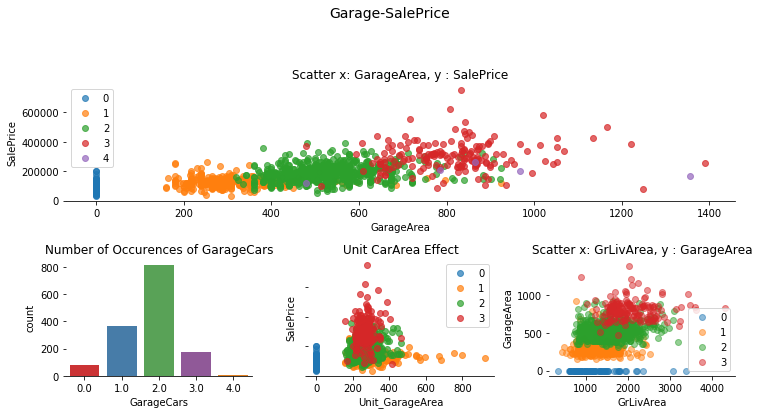

In [285]:
garage = ['GarageCars', 'GarageArea']
plt.figure(figsize = (12,6))
#########################################################################################
ax2 = plt.subplot2grid((2,3), (1,0))
palette = sns.color_palette('Set1',5)
sns.countplot(train['GarageCars'], ax = ax2, palette = palette)
ax2.set_title('Number of Occurences of GarageCars')
#########################################################################################
ax3 = plt.subplot2grid((2,3), (0,0), colspan = 3)

for val in range(5):
    indexV = train.GarageCars == val
    ax3.plot(train['GarageArea'].loc[indexV], train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Scatter x: GarageArea, y : SalePrice')
#ax3.set_yticklabels([])
ax3.legend()
#########################################################################################
ax = plt.subplot2grid((2,3), (1,2))
num = [0,1,2,3]

for val in num:
    index = train.GarageCars == val
    ax.scatter(train.GrLivArea.loc[index], train.GarageArea.loc[index], label = val, alpha = 0.5)
ax.set_xlabel('GrLivArea')
ax.set_ylabel('GarageArea')
ax.set_title('Scatter x: GrLivArea, y : GarageArea')
ax.legend()

def functions(x):
    if x['GarageCars'] == 0: return 0
    else:
        return x['GarageArea']/ x['GarageCars']
unitCarArea = train.apply(functions, axis = 1)
#########################################################################################
ax3= plt.subplot2grid((2,3), (1,1))

for val in range(4):
    indexV = train.GarageCars == val
    ax3.plot(unitCarArea.loc[indexV], train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('Unit_GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Unit CarArea Effect')
ax3.set_yticklabels([])
ax3.legend()

sns.despine(left = True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5, top =0.8)
plt.suptitle('Garage-SalePrice', fontsize = 14)
plt.show()
#df_train.GarageCars.loc[df_train.GarageCars == 4] = 3

* Most of houses have two cars
* GarageArea makes Chunk having small lineratiy with SalePrice
* 0 Cars and 1 Cars has no difference in SalePrice
* 4 Cars are simliar with 3 Cars house. Merge them
* (Update) Unt_Garage Area said that "Expensive house sustain the proper line of the area!"
* (Update) GrLivArea is a good variable not related to GarageArea. Those two variables enforces the prediction power.